### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
connection= sqlite3.connect('final.sqlite')
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
final_data = pd.read_sql_query("select * from Reviews ORDER BY Time ASC limit 100000 ",connection)

In [3]:
data = final_data['Text']

In [4]:
labels = final_data['Score']

def lab_to_bin(x):
    if x == 'positive':
        return 1
    else:
        return 0
labels_bin = labels.map(lab_to_bin)

In [5]:
labels_bin.value_counts()


1    87729
0    12271
Name: Score, dtype: int64

In [6]:
from sklearn.utils import compute_class_weight

In [7]:
weight = compute_class_weight('balanced',np.unique(labels_bin),labels_bin)

In [8]:
weight

array([4.07464754, 0.56993696])

class 0 is weighted by 4.0746 and class 1 is weighted by 0.56

In [9]:
weight_dict = {1:0.56,0:4.07}

In [10]:
from sklearn.model_selection import train_test_split

X_1, X_test, y_1, y_test = train_test_split(final_data['Text'], labels_bin, test_size=0.3, random_state=0,shuffle= False)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

# Word2vec model

In [11]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    

In [12]:
import re
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /Users/sapan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sentence_tr=[]
for sentence in X_tr.values:
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    for words in sentence.split():
        for cleaned_words in cleanpunc(words).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentence_tr.append(filtered_sentence)

i=0
list_of_sentence_cv=[]
for sentence in X_cv.values:
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    for words in sentence.split():
        for cleaned_words in cleanpunc(words).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentence_cv.append(filtered_sentence)
i=0
list_of_sentence_test=[]
for sentence in X_test.values:
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    for words in sentence.split():
        for cleaned_words in cleanpunc(words).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentence_test.append(filtered_sentence)

In [14]:
w2v_model=gensim.models.Word2Vec(list_of_sentence_tr,min_count=5,size=50, workers=4)

In [15]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13686
sample words  ['i', 'ordered', 'this', 'product', 'from', 'amazon', 'in', 'feb', 'first', 'week', 'and', 'have', 'yet', 'to', 'get', 'my', 'shipment', 'is', 'one', 'of', 'the', 'better', 'sore', 'throat', 'teas', 'ive', 'found', 'trust', 'me', 'went', 'through', 'quite', 'a', 'few', 'taste', 'alone', 'would', 'make', 'tea', 'worth', 'drinking', 'but', 'mint', 'other', 'flavors', 'it', 'especially', 'soothing', 'also', 'helps']


In [17]:
import numpy as np
# average Word2Vec
# compute average word2vec for each review.
sentence_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in list_of_sentence_tr: # for each review/sentence
    sentence_vector_tr = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        try:
            vector = w2v_model.wv[word]
            sentence_vector_tr += vector
            count_words += 1
        except:
            pass
    sentence_vector_tr /= count_words
    sentence_vectors_tr.append(sentence_vector_tr)
print(len(sentence_vectors_tr))
print(len(sentence_vectors_tr[0]))

49000
50


In [18]:
import numpy as np
# average Word2Vec
# compute average word2vec for each review.
sentence_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in list_of_sentence_cv: # for each review/sentence
    sentence_vector_cv = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        try:
            vector = w2v_model.wv[word]
            sentence_vector_tr += vector
            count_words += 1
        except:
            pass
    sentence_vector_tr /= count_words
    sentence_vectors_cv.append(sentence_vector_tr)
print(len(sentence_vectors_cv))
print(len(sentence_vectors_cv[0]))

21000
50


In [19]:
import numpy as np
# average Word2Vec
# compute average word2vec for each review.
sentence_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in list_of_sentence_test: # for each review/sentence
    sentence_vector_test = np.zeros(50) # as word vectors are of zero length
    count_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        try:
            vector = w2v_model.wv[word]
            sentence_vector_tr += vector
            count_words += 1
        except:
            pass
    sentence_vector_tr /= count_words
    sentence_vectors_test.append(sentence_vector_tr)
print(len(sentence_vectors_test))
print(len(sentence_vectors_test[0]))

30000
50


In [23]:
from sklearn import preprocessing
sentence_vectors_tr = preprocessing.normalize(sentence_vectors_tr)
sentence_vectors_cv = preprocessing.normalize(sentence_vectors_cv)
sentence_vectors_test = preprocessing.normalize(sentence_vectors_test)

In [25]:
depth = [x for x in range(1, 21)]
depth

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [26]:
cv_scores = []
for d in depth:
    clf = DecisionTreeClassifier(max_depth = d,class_weight=weight_dict)
    scores = cross_val_score(clf, sentence_vectors_tr, y_tr, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

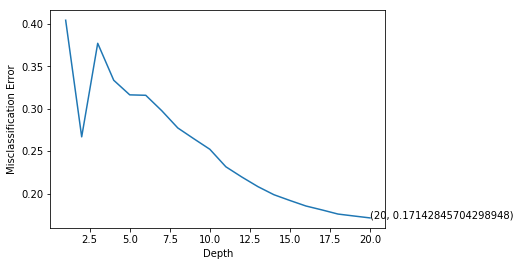

In [28]:
error = [1 - x for x in cv_scores]
optimal_depth = depth[error.index(min(error))]
plt.plot(depth, error)
xy = (optimal_depth, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Depth")
plt.ylabel("Misclassification Error")
plt.show()


In [29]:
clf = DecisionTreeClassifier(max_depth = 20,class_weight=weight_dict) # MAx depth obtained from CV.
clf.fit(sentence_vectors_tr, y_tr,)

DecisionTreeClassifier(class_weight={1: 0.56, 0: 4.07}, criterion='gini',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
clf.score(sentence_vectors_test, y_test)

0.8633333333333333

In [36]:
pred = clf.predict(sentence_vectors_test)

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


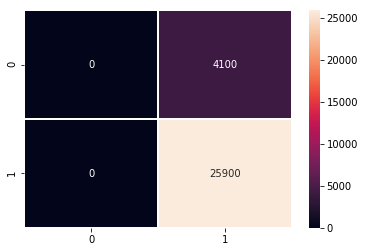

In [37]:
matrix = confusion_matrix(y_test,pred)
import seaborn as sns
sns.heatmap(matrix,annot=True,fmt="d",linewidths=.5)
plt.show()

In [38]:

print("Accuracy on cv set for tf-idf: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for tf-idf: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for tf-idf: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for tf-idf: %0.3f"%(f1_score(y_test, pred)))


Accuracy on cv set for tf-idf: 86.333%
Precision on cv set for tf-idf: 0.863
Recall on cv set for tf-idf: 1.000
F1-Score on cv set for tf-idf: 0.927


# Avg Word2Vec TF-IDF

In [82]:
from tqdm import tqdm

In [83]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(data.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [84]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:    
                tf_idf = dictionary[word] * sent.count(word)
            except KeyError:
                tf_idf = 0
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 49000/49000 [02:56<00:00, 277.39it/s]


In [85]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:    
                tf_idf = dictionary[word] * sent.count(word)
            except KeyError:
                tf_idf = 0
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 21000/21000 [01:15<00:00, 279.86it/s]


In [86]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            try:    
                tf_idf = dictionary[word] * sent.count(word)
            except KeyError:
                tf_idf = 0
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [01:51<00:00, 268.87it/s]


In [87]:
tfidf_sent_vectors_tr = preprocessing.normalize(tfidf_sent_vectors_tr)
tfidf_sent_vectors_cv = preprocessing.normalize(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test = preprocessing.normalize(tfidf_sent_vectors_test)

In [88]:
cv_scores = []
for d in depth:
    clf = DecisionTreeClassifier(max_depth = d,class_weight=weight_dict)
    scores = cross_val_score(clf, tfidf_sent_vectors_tr, y_tr, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

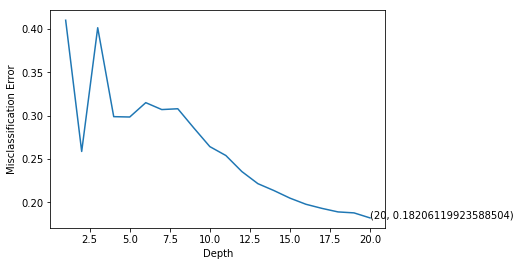

In [89]:
error = [1 - x for x in cv_scores]
optimal_depth = depth[error.index(min(error))]
plt.plot(depth, error)
xy = (optimal_depth, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Depth")
plt.ylabel("Misclassification Error")
plt.show()


In [90]:
clf = DecisionTreeClassifier(max_depth = 5,class_weight=weight_dict) # MAx depth obtained from CV.
clf.fit(tfidf_sent_vectors_tr, y_tr)

DecisionTreeClassifier(class_weight={1: 0.56, 0: 4.07}, criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [91]:
clf.score(tfidf_sent_vectors_test, y_test)

0.6862666666666667

In [92]:
pred = clf.predict(tfidf_sent_vectors_test)

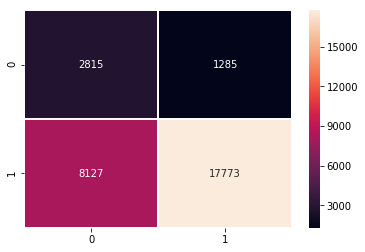

In [93]:
matrix = confusion_matrix(y_test,pred)
import seaborn as sns
sns.heatmap(matrix,annot=True,fmt="d",linewidths=.5)
plt.show()

In [94]:
print("Accuracy on cv set for tf-idf: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for tf-idf: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for tf-idf: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for tf-idf: %0.3f"%(f1_score(y_test, pred)))


Accuracy on cv set for tf-idf: 68.627%
Precision on cv set for tf-idf: 0.933
Recall on cv set for tf-idf: 0.686
F1-Score on cv set for tf-idf: 0.791


# Bag of Words

In [16]:
#Creating bag of words and vectorizing it
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,2),dtype=float) 
final_counts_tr = count_vect.fit_transform(X_tr.values)
final_counts_cv = count_vect.transform(X_cv.values)
final_counts_test = count_vect.transform(X_test.values)
final_counts_tr = preprocessing.normalize(final_counts_tr)
final_counts_cv = preprocessing.normalize(final_counts_cv)
final_counts_test = preprocessing.normalize(final_counts_test)

In [17]:
depth = [x for x in range(1, 40,5)]
depth

[1, 6, 11, 16, 21, 26, 31, 36]

In [18]:

cv_scores = []
for d in depth:
    clf = DecisionTreeClassifier(max_depth = d,class_weight=weight_dict,max_features=3000) #we are taking only top 3000 features 
    scores = cross_val_score(clf, final_counts_tr, y_tr, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

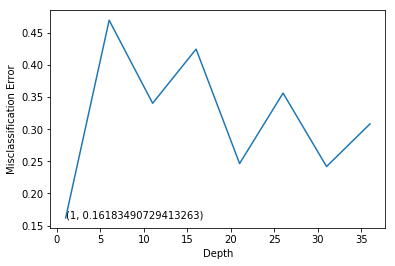

In [19]:
error = [1 - x for x in cv_scores]
optimal_depth = depth[error.index(min(error))]
plt.plot(depth, error)
xy = (optimal_depth, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Depth")
plt.ylabel("Misclassification Error")
plt.show()


In [20]:
clf = DecisionTreeClassifier(max_depth = 1,class_weight=weight_dict) # MAx depth obtained from CV.
clf.fit(final_counts_tr, y_tr)

DecisionTreeClassifier(class_weight={1: 0.56, 0: 4.07}, criterion='gini',
            max_depth=1, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [21]:
clf.score(final_counts_test, y_test)

0.3392

In [22]:
pred = clf.predict(final_counts_test)

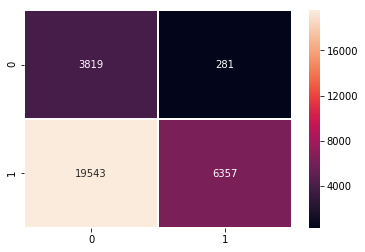

Accuracy on cv set for tf-idf: 33.920%
Precision on cv set for tf-idf: 0.958
Recall on cv set for tf-idf: 0.245
F1-Score on cv set for tf-idf: 0.391


In [23]:
matrix = confusion_matrix(y_test,pred)
import seaborn as sns
sns.heatmap(matrix,annot=True,fmt="d",linewidths=.5)
plt.show()
print("Accuracy on cv set for tf-idf: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for tf-idf: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for tf-idf: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for tf-idf: %0.3f"%(f1_score(y_test, pred)))

In [24]:
df= clf.feature_importances_

In [25]:
import pandas as pd
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_100_pos = likelihood_df.sort_values(by='Score',ascending=False).iloc[:100]
top_100_pos.reset_index(inplace=True)
top_words_pos = top_100_pos['index']

In [26]:
top_words_pos

0                  great
1               populous
2      population krinos
3          population of
4     population product
5        population such
6        population that
7        population want
8         population who
9            populations
10        populations in
11                 popup
12       porcelain maual
13          popup spigot
14                   por
15            por aacute
16               por dia
17              por dias
18              por kwan
19               por sub
20               por una
21             porcelain
22         population is
23                    00
24      population found
25        population for
26         popularity in
27         popularity is
28         popularity it
29         popularity my
             ...        
70             porch had
71             porch all
72             porcelana
73         porcelana bar
74        porcelana bars
75       porcelana being
76         porcelana but
77          porcelana is
78     porcelana variety


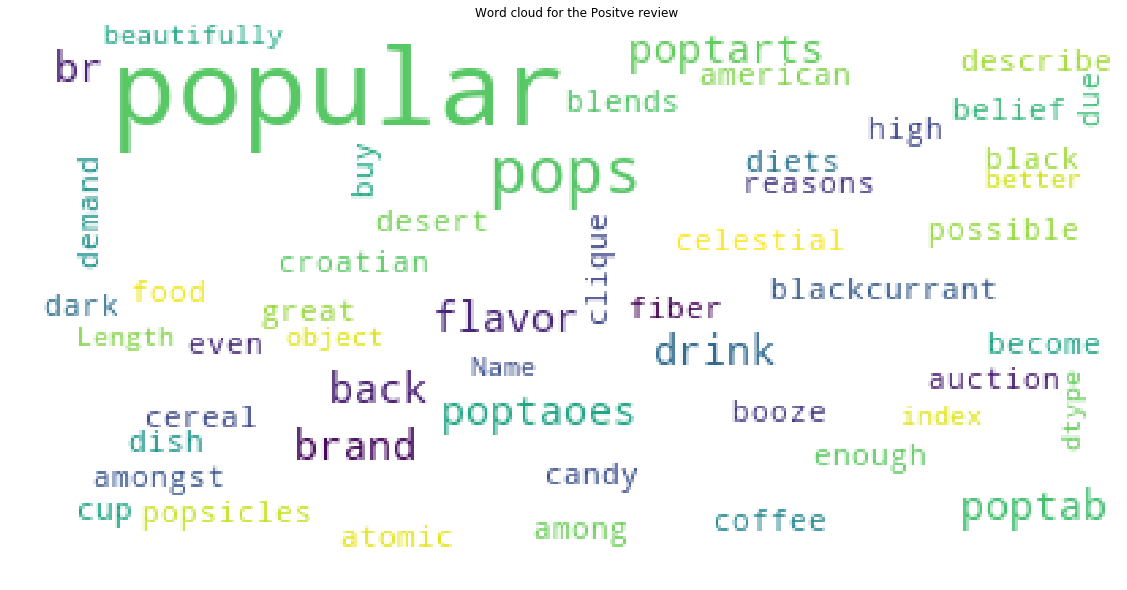

In [43]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                        max_words=100,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_words_pos))
print(wordcloud)
fig = plt.figure(1,figsize=(20,10))
plt.title("Word cloud for the Positve review")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [39]:
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_100_neg = likelihood_df.sort_values(by='Score',ascending=True).iloc[:100]
top_100_neg.reset_index(inplace=True)
top_words_neg = top_100_neg['index']

In [40]:
top_words_neg

0                       00
1               popular as
2               popular at
3          popular auction
4             popular back
5          popular because
6           popular become
7           popular belief
8            popular black
9              popular and
10    popular blackcurrant
11           popular booze
12              popular br
13           popular brand
14          popular brands
15             popular but
16             popular buy
17           popular candy
18       popular celestial
19          popular blends
20         popular amongst
21           popular among
22        popular american
23                poptaoes
24           poptaoes high
25                poptarts
26            poptarts and
27        poptarts because
28         poptarts better
29           poptarts even
              ...         
70          popular coffee
71        popular croatian
72             popular cup
73            popular dark
74          popular demand
75        popular describe
7

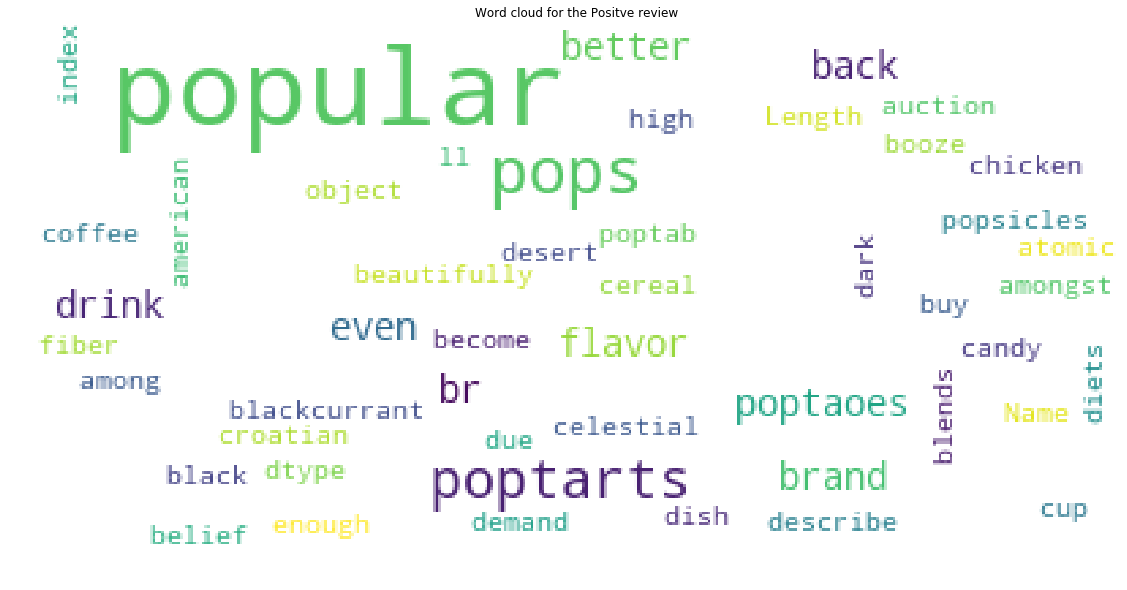

In [44]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                        max_words=100,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_words_neg))
print(wordcloud)
fig = plt.figure(1,figsize=(20,10))
plt.title("Word cloud for the Positve review")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# TF-IDF 

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_tr = tf_idf_vect.fit_transform(X_tr.values)
tf_idf_cv = tf_idf_vect.transform(X_cv.values)
tf_idf_test = tf_idf_vect.transform(X_test.values)

In [56]:
from sklearn import preprocessing
tf_idf_tr = preprocessing.normalize(tf_idf_tr)
tf_idf_cv = preprocessing.normalize(tf_idf_cv)
tf_idf_test = preprocessing.normalize(tf_idf_test)

In [57]:
depth = [x for x in range(1, 30,5)]
depth

[1, 6, 11, 16, 21, 26]

In [58]:
cv_scores = []
for d in depth:
    clf = DecisionTreeClassifier(max_depth = d,class_weight=weight_dict,max_features=3000)
    scores = cross_val_score(clf, tf_idf_tr, y_tr, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

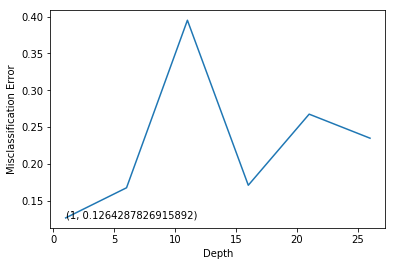

In [59]:
error = [1 - x for x in cv_scores]
optimal_depth = depth[error.index(min(error))]
plt.plot(depth, error)
xy = (optimal_depth, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Depth")
plt.ylabel("Misclassification Error")
plt.show()


In [60]:
clf = DecisionTreeClassifier(max_depth = 1,class_weight=weight_dict) # MAx depth obtained from CV.
clf.fit(tf_idf_tr, y_tr)

DecisionTreeClassifier(class_weight={1: 0.56, 0: 4.07}, criterion='gini',
            max_depth=1, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [61]:
clf.score(tf_idf_test, y_test)

0.3234

In [62]:
pred = clf.predict(tf_idf_test)

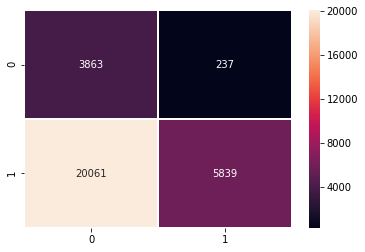

Accuracy on cv set for tf-idf: 32.340%
Precision on cv set for tf-idf: 0.961
Recall on cv set for tf-idf: 0.225
F1-Score on cv set for tf-idf: 0.365


In [35]:
matrix = confusion_matrix(y_test,pred)
import seaborn as sns
sns.heatmap(matrix,annot=True,fmt="d",linewidths=.5)
plt.show()
print("Accuracy on cv set for tf-idf: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on cv set for tf-idf: %0.3f"%(precision_score(y_test, pred)))
print("Recall on cv set for tf-idf: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on cv set for tf-idf: %0.3f"%(f1_score(y_test, pred)))


In [36]:
df= clf.feature_importances_

In [37]:
import pandas as pd

words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_100_pos = likelihood_df.sort_values(by='Score',ascending=False).iloc[:100]
top_100_pos.reset_index(inplace=True)
top_words_pos = top_100_pos['index']

In [38]:
top_100_pos

,index,Score
0,great,1.0
1,populous,0.0
2,population krinos,0.0
3,population of,0.0
4,population product,0.0
5,population such,0.0
6,population that,0.0
7,population want,0.0
8,population who,0.0
9,populations,0.0


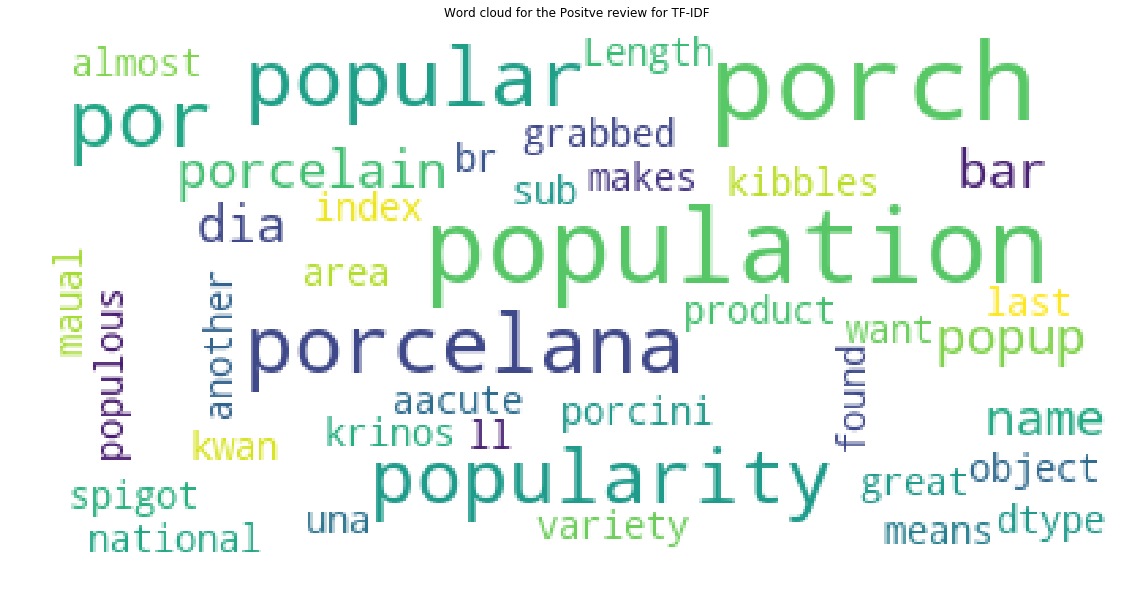

In [39]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                        max_words=100,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_words_pos))
print(wordcloud)
fig = plt.figure(1,figsize=(20,10))
plt.title("Word cloud for the Positve review for TF-IDF")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [40]:
import pandas as pd
words = count_vect.get_feature_names()
likelihood_df = pd.DataFrame(clf.feature_importances_.transpose(),columns=[ 'Score'],index=words)
top_100_neg = likelihood_df.sort_values(by='Score',ascending=True).iloc[:100]
top_100_neg.reset_index(inplace=True)
top_words_neg = top_100_neg['index']

In [41]:
top_words_neg

0                     00
1          population of
2     population product
3        population such
4        population that
5        population want
6         population who
7            populations
8         populations in
9      population krinos
10              populous
11          popup spigot
12                   por
13            por aacute
14               por dia
15              por dias
16              por kwan
17               por sub
18               por una
19                 popup
20         population is
21      population found
22        population for
23         popularity in
24         popularity is
25         popularity it
26         popularity my
27     popularity points
28       popularity they
29       popularity will
             ...        
70             porcelana
71         porcelana bar
72        porcelana bars
73       porcelana being
74         porcelana but
75          porcelana is
76     porcelana variety
77                 porch
78             porch all


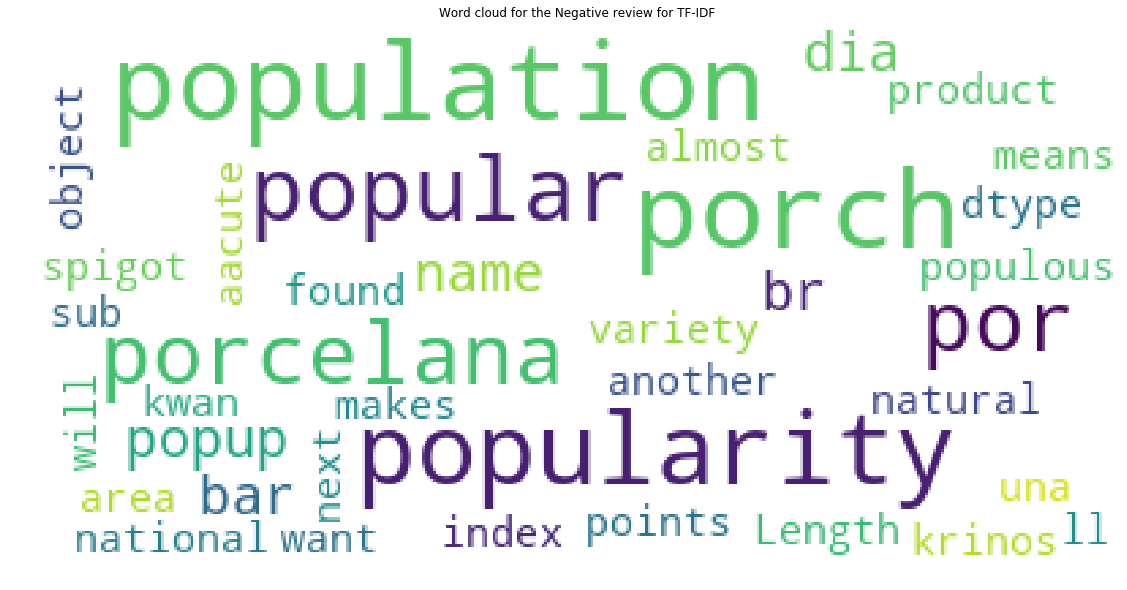

In [42]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                        max_words=100,
                          max_font_size=40, 
                          random_state=42,
                         ).generate(str(top_words_neg))
print(wordcloud)
fig = plt.figure(1,figsize=(20,10))
plt.title("Word cloud for the Negative review for TF-IDF")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [43]:
!echo $PATH

/Users/sapan/anaconda3/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Applications/VMware Fusion.app/Contents/Public


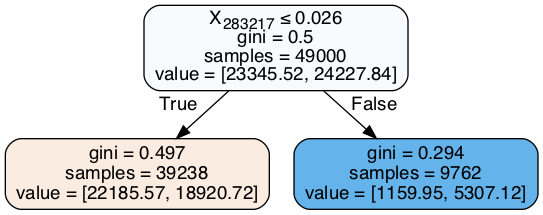

In [67]:
from IPython.display import Image 
from sklearn.tree import export_graphviz
from io import StringIO
from sklearn import tree
import pydotplus
dot_data = StringIO()
export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

changing depth value to understand how decision tree works

In [69]:
clf = DecisionTreeClassifier(max_depth = 3,class_weight=weight_dict) # MAx depth obtained from CV.
clf.fit(tf_idf_tr, y_tr)

DecisionTreeClassifier(class_weight={1: 0.56, 0: 4.07}, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

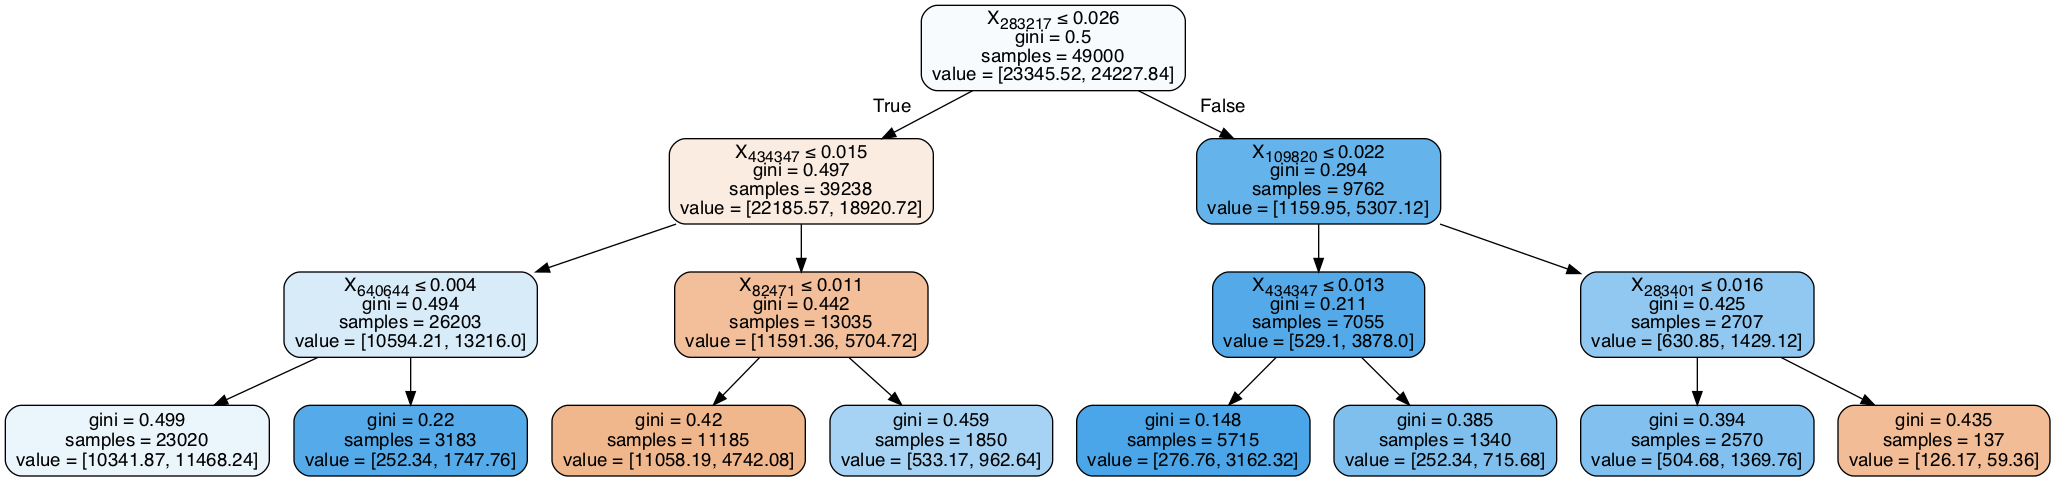

In [70]:
from IPython.display import Image 
from sklearn.tree import export_graphviz
from io import StringIO
from sklearn import tree
import pydotplus
dot_data = StringIO()
export_graphviz(clf,out_file=dot_data,filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# Conclusions

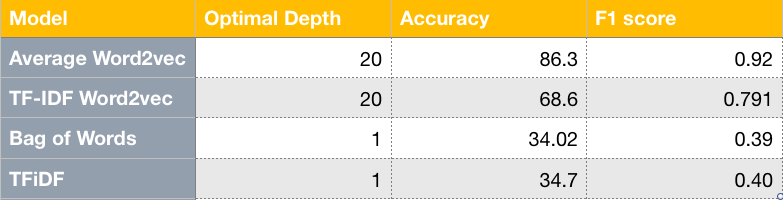
1. We can see from the above that Decision tree is not working good on BoW and TF-IDF  as they have high dimensions 
2. Also for word2vec model , classifier is only predicting positive class
3. TF-IDF Word2vec is has got most accuracy of 68 % 
4. We should not use  Decsion tree classifer as SVM , logistic regression and Naive Bayes outperform Decision tree in this problem